# The use and misuse of over-representation pathway enrichment analysis in metabolomics

#### This notebook contains the code to run the following simulations:
1. Background list
- Background list size reduction
- <a href='#s2'>DA metabolite list size</a>
- <a href='#s3'>General vs. organism-specific pathway set</a>
- Metabolite misidentification

#### The following scripts are required to be able to run the code. They should be saved in the same folder as this notebook. 
- process_datasets.py: Pre-processing of abundance matrices for the required datasets. 
- utils.py: Utilities for t-tests, ORA, and simulations.

All packages required are listed in the requirements.txt file. All simulations have been tested using Python version 3.8

In [ ]:
pip install -r requirements.txt # install the required packages

In [1]:
import utils
import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Import the relevant datasets
DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

# Import pathway sets
KEGG_reference_pathways = pd.read_csv("KEGG_reference_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

# param grid
datasets = {"Auwerx": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg, mat_auwerx, [i for i in range(0, 14, 1)], [i for i in range(0, 12, 1)]],
            "Yamada": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg, mat_yamada, [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)]],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg, mat_stevens],
            "Brown": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg, mat_brown, [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)]],
            "Zamboni (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg, mat_yfgM, [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)]],
            "Zamboni (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg, mat_dcuS, [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)]]}

print("Data import complete")

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Data import complete


<a id='s2'></a>
## List of input metabolites

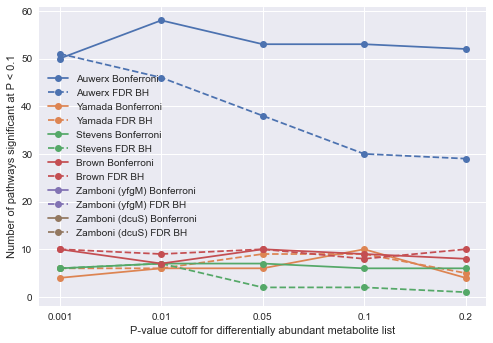

In [5]:
def vary_p_val_cutoff():
    p_value_cutoffs = [0.001, 0.01, 0.05, 0.1, 0.2]
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in ['Auwerx', 'Yamada', 'Stevens', 'Brown']:
        for p in p_value_cutoffs:
            for m in multiple_test_options:
                t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                DA_metabolites = t_test_res[t_test_res["P-adjust"] < p]["Metabolite"].tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, p, m, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "Multiple_correction_method", "n_p_less_01"])
    res_df_bonferroni = res_df[res_df["Multiple_correction_method"] == "bonferroni"]
    res_df_FDR_BH = res_df[res_df["Multiple_correction_method"] == "fdr_bh"]
    with plt.style.context('seaborn'):
        fig, ax1 = plt.subplots(1, 1)
        plt.style.use("seaborn")
        cols = sns.color_palette("deep", 8)

        for num, i in enumerate(datasets.keys()):
            ax1.plot(res_df_bonferroni[res_df_bonferroni["Dataset"] == i]['Cutoff_P'].to_numpy().astype('str'),
                         res_df_bonferroni[res_df_bonferroni["Dataset"] == i]['n_p_less_01'].tolist(), 'o', label=i+" Bonferroni", linestyle='-', color=cols[num])
            ax1.plot(res_df_FDR_BH[res_df_FDR_BH["Dataset"] == i]['Cutoff_P'].to_numpy().astype('str'),
                         res_df_FDR_BH[res_df_FDR_BH["Dataset"] == i]['n_p_less_01'].tolist(), 'o', label=i+" FDR BH", linestyle='--', color=cols[num])
        # plt.title("Reactome", fontsize=14)

        ax1.legend()
        ax1.set_ylabel("Number of pathways significant at P < 0.1")
        ax1.set_xlabel("P-value cutoff for differentially abundant metabolite list")
#         plt.savefig("../Figures/KEGG_p_value_cutoffs.png", dpi=300)
        plt.show()

vary_p_val_cutoff()

<a id='s3'></a>
## General vs. organism-specific pathway set

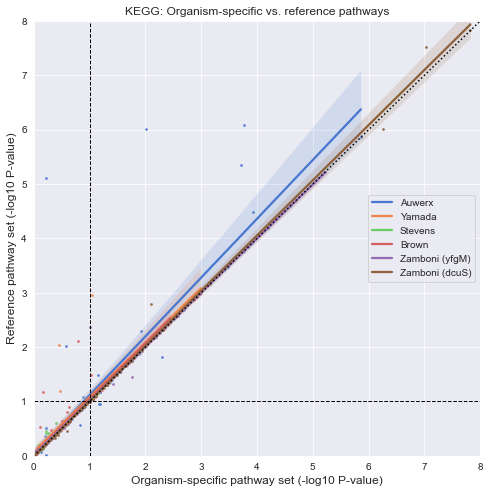

In [5]:
def organism_vs_reference(db="KEGG"):
    d_sets = datasets
    # if db == "Reactome":
    #     d_sets = datasets_reactome
    # if db == "Cyc":
    #     d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res_org = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_ref = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], KEGG_reference_pathways)
        intersect = (set(ora_res_org["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref["Pathway_ID"].str.slice(start=-5).tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_ref = ora_res_ref[ora_res_ref["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org = ora_res_org[ora_res_org["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org_pvals = np.negative(np.log10(ora_res_org["P-value"].tolist()))
        ora_res_ref_pvals = np.negative(np.log10(ora_res_ref["P-value"].tolist()))
        plt_dict[i] = [ora_res_org_pvals, ora_res_ref_pvals]

    plt.figure(figsize=(8, 8))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]

        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 3})
    ax.set_xlabel("Organism-specific pathway set (-log10 P-value)",
                  fontsize=12)
    ax.set_ylabel("Reference pathway set (-log10 P-value)",
                  fontsize=12)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG: Organism-specific vs. reference pathways")
#     plt.savefig("../Figures/organism_vs_reference_pathways_pvals.png", dpi=300)
    plt.show()

organism_vs_reference()

#### Calculate average pathway size

In [3]:
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [4]:
ref_paths = process_paths(KEGG_reference_pathways)
human_paths = process_paths(KEGG_human_pathways)
avg_ref_pathway_size = np.mean([len(v) for k, v in ref_paths.items()])
avg_hum_pathway_size = np.mean([len(v) for k, v in human_paths.items()])
# mouse_pathway_size = 
# eco_pathway_size = 
print("Average reference pathway size:", avg_ref_pathway_size)
print("Average human pathway size:", avg_hum_pathway_size)
print("Total reference pathways:", len(ref_paths))
print("Total human pathways:", len(human_paths))

Average reference pathway size: 44.88859416445624
Average human pathway size: 29.582375478927204
Total reference pathways: 377
Total human pathways: 261


#### Calculate Jaccard index for common pathways

In [13]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [6]:
common_paths_ref_human = list(set([i[3:] for i in ref_paths.keys()]) & set([i[3:] for i in human_paths.keys()]))

In [31]:
jaccard_indexes_human_ref = []
for pathway_id in common_paths_ref_human:
    jaccard_index = jaccard_similarity(ref_paths["map"+str(pathway_id)], human_paths["hsa"+str(pathway_id)])
    jaccard_indexes_human_ref.append(jaccard_index)
    
print("Average Jaccard index for common reference and human pathways:", np.mean(jaccard_indexes_human_ref))

Average Jaccard index for common reference and human pathways: 0.7489924529127291


In [10]:
for path in common_paths_ref_human:
    print(len(ref_paths["map"+str(path)]), len(human_paths["hsa"+str(path)]), path)
    print(ref_paths["map"+str(path)], human_paths["hsa"+str(path)])

4 5 04670
['C00027', 'C00076', 'C00575', 'C04637'] ['C00027', 'C00076', 'C00076', 'C00575', 'C04637']
33 48 00920
['C00033', 'C00042', 'C00053', 'C00054', 'C00059', 'C00065', 'C00084', 'C00087', 'C00094', 'C00097', 'C00155', 'C00224', 'C00245', 'C00263', 'C00283', 'C00320', 'C00409', 'C00580', 'C00979', 'C01118', 'C01861', 'C02084', 'C03920', 'C04022', 'C08276', 'C11142', 'C11143', 'C11145', 'C15521', 'C17267', 'C19692', 'C20870', 'C20955'] ['C00059', 'C00094', 'C00283', 'C00224', 'C00054', 'C00053', 'C11142', 'C11145', 'C11143', 'C00580', 'C00409', 'C04022', 'C03920', 'C19692', 'C01861', 'C02084', 'C00320', 'C00087', 'C00097', 'C00979', 'C00033', 'C00065', 'C08276', 'C00155', 'C01118', 'C00042', 'C00263', 'C00245', 'C15521', 'C00059', 'C00245', 'C15521', 'C00059', 'C00053', 'C00224', 'C00094', 'C00059', 'C00224', 'C00094', 'C00283', 'C00059', 'C00320', 'C00283', 'C19692', 'C20870', 'C20955', 'C00084', 'C17267']
8 8 04211
['C00003', 'C00020', 'C00076', 'C00575', 'C03582', 'C05981', 'C0

In [12]:
print(int(3.889))

3


In [ ]:
python